In [1]:
%run Latex_macros.ipynb
%run beautify_plots.py

<IPython.core.display.Latex object>

In [2]:
# My standard magic !  You will see this in almost all my notebooks.

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Reload all modules imported with %aimport
%load_ext autoreload
%autoreload 1

%matplotlib inline

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
 
import recipe_helper
%aimport recipe_helper

import transform_helper
%aimport transform_helper


In [4]:
# Create plots for Fundamental Assumption
ssm = transform_helper.StockPrice_shiftedMean_Helper()
ss_df = ssm.gen_prices(.001, .02, [10, 20], num_returns=252)
fig_data, axs_data = ssm.plot_data(ss_df, visible=False)
fig_segs, axs_segs = ssm.plot_segments(ss_df, visible=False)

# Prepare data: transformations

Transforming data (Recipe C.3) may be **the most important** step of the multi-step Recipe !

<table>
    <tr>
        <th><center>Recipe for Machine Learning</center></th>
    </tr>
    <tr>
        <td><img src="images/W1_L3_S4_ML_Process.png" width="100%"></td>
    </tr>
</table>

It is often the case that the "raw" features given to us don't suffice 
- we may need to create "synthetic" features.  
- This is called **feature engineering**.

Recall: our "curvy" data set from the previous lecture:

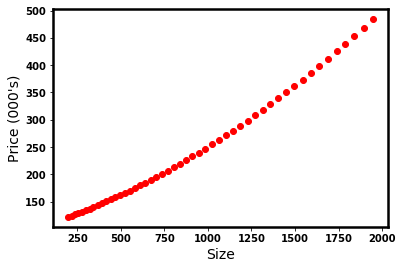

In [5]:
(xlabel, ylabel) = ("Size", "Price (000's)")
v1, a1 = 1, .005
v2, a2 = v1, a1*2
curv = recipe_helper.Recipe_Helper(v = v2, a = a2)
X_curve, y_curve = curv.gen_data(num=50)
_= curv.gen_plot(X_curve,y_curve, xlabel, ylabel)

And compare the out of sample performance on this data set
- On a linear model (single, raw feature)
- On a model with a second feature (squared version of raw feature)


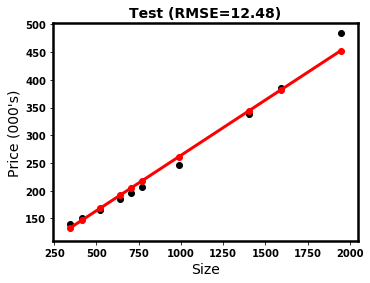

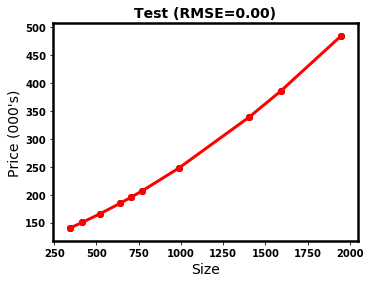

In [6]:
model_results = curv.compare_regress(X_curve, y_curve, xlabel=xlabel, ylabel=ylabel, visible=True, plot_train=False)


Adding the synthetic feature was key to better performance (lower RMSE).


Or recall the stock whose price jumped at one instant

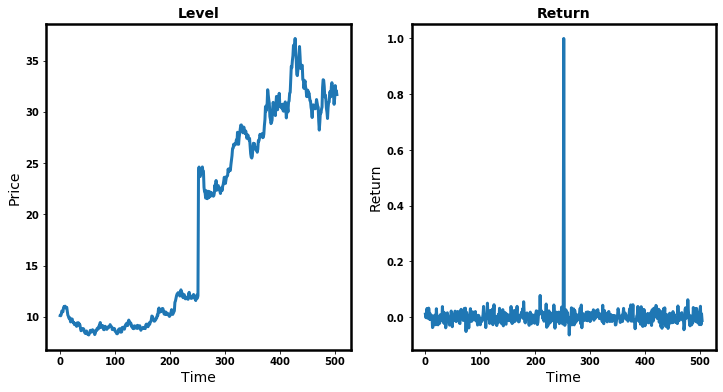

In [7]:
fig_data

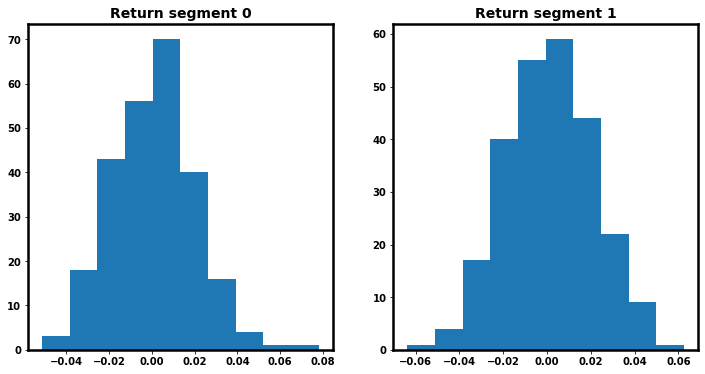

In [8]:
fig_segs

We would probably have better luck
- predicting future *returns* from past returns
- compared to predicting future *prices* from past prices

That is: the synthetic feature ("Return") replaces the raw feature ("Price").

We could also argue that adding an additional synthetic feature might facilitate using Price as a feature:
- a time index
- or indicator (true/false)
that identifies examples as being either pre or post jump

It will still be better using Return rather than Level and a segment indicator
- A jump can occur **within** the training data
    - or each example could drift weakly over time
- Excluding the jump: Returns are stable over time
    - but Price (and Price changes) **are not**
    - same return applied to a larger Price results in a larger Price change

In order to learn, it helps to have *training* data be more homogeneous
- Can more easily learn a pattern from many examples rather than a handful
- So can benefit from making the training examples more similar to one another
    - not just making training and test examples look similar

Either way: transforming the raw features is key to successful modeling and prediction.

*Feature engineering (transformations)*
- takes an example: vector $\x^\ip$ with $n$ features
- produces a new vector $\tilde\x^\ip$, with $n'$ features

We ultimately fit the model with the transformed *training* examples.

We can apply multiple transformations, each
- Adding new synthetic features
- Further transforming synthetic features


<table>
    <tr>
        <th><center>Feature Engineering</center></th>
    </tr>
    <tr>
        <td><img src="images/Feature_engineering.png"</td>
    </tr>
</table>
​

The above diagram shows multiple transformations
- organized as a sequence (sometimes called a *pipeline*) of independent transformations $T_1, T_2, \ldots, T_t$

$$
\begin{array}[lll] \\
\tilde{\x}_{(1)} = T_1( \x ) \\
\tilde{\x}_{(2)} = T_2( \tilde{\x}_{(1)} ) \\
\vdots \\
\tilde{\x}_{(\ll+1)} = T_{(\ll+1)}( \tilde{\x}_{(\ll)} ) \\
\end{array}
$$

We write the final transformed $\tilde{\x}$ as a function $T$ that is the composition
of each transformation function
$$
\tilde{\x} = T(\x) = T_t( \; T_{t-1}( \ldots T_1(\x) \ldots ) \; )
$$

The length of the final transformed vector $\tilde{\x}$
may differ from the $n$, the length of the input $\x$
- may add features
- may drop features

The predictions are now a function of $\tilde{\x}$ rather than $\x$

$$
\begin{array}\\
\hat{\y} & = & h_\Theta (\tilde{\x} ) \\
\end{array}
$$


## Example transformation: Missing data imputation

The first transformation we encountered added a feature ($\x^2$ term) that improved prediction.

Some transformations alter existing features rather than adding new ones.

Transformations in detail will be the subject of a separate lecture but let's cover the basics.

Let's consider a second reason for transformation: filling in (imputing) missing data for a feature.

$#$ | $\mathbf{x}_1$ | $\mathbf{x}_2$
 -- | ----- | ----
1   | 1.0   | 10
2   | 2.0   | 20
$\vdots$ | $\vdots$ | $\vdots$ 
i   | 2.0   |  NaN
$\vdots$ | $\vdots$ | $\vdots$ 
m   | $\ldots$

In the above: feature $\x_2$ is missing a value in example $i$: $\x^\ip_2 = \text{NaN} $

We will spend more time later discussing the various ways to deal with missing data imputation.

For now: let's adopt the common strategy of replacing it with the median of the defined values:

$$\text{median}(\x_2) = \text{median}( \{ \x^\ip_2 | 1 \le i \le m, \x^\ip_2 \ne \text{NaN} \} )$$

This imputation is a kind of data transformation: replacing an undefined value.

Without this transformation: the algorithm that implements our model
- May fail
- May impute a less desirable value, since it lacks specific knowledge of our problem

#  "Fitting" transformations

The behavior of our models for prediction have parameters $\Theta$.

It might not be obvious that transformations have parameters $\Theta_\text{transform}$ as well

$$
\begin{array}\\
\tilde{\x} = T_{\Theta_\text{transform}}(\x) \\
\end{array}
$$

For example: when missing data imputation for a feature substitutes the mean/median feature value
- $\Theta_\text{transform}$ stores this value

We use the term "fitting" to describe the process of solving for $\Theta_\text{transform}$
- Unlike $\Theta$, one doesn't usually find a "optimal" value for $\Theta_\text{transform}$

Our prediction is thus
$$
\begin{array}\\
\hat{\y} & = & h_\Theta (\tilde{\x}) \\
& = &h_\Theta( \, T_{\Theta_\text{transform}}(\x) \,)
\end{array}
$$


The process of Transformations is similar to fitting a model and predicting.

The parameters in $\Theta_\text{transform}$ 
- are "fit" by examining all training data $\X$
- once fit, we can transform ("predict") *any* example (whether it be training/validation or test)

## Applying transformations consistently

Since the prediction is now
$$
\begin{array}[lll]\\
\hat{\y} & = & h_\Theta( \, \tilde{\x} \,) &  \text{ where } \tilde{\x} = T_{\Theta_\text{transform}} (\x) \\
\end{array}
$$
**each and every** input $\x$ must be transformed
- Training examples
- Test examples

That is: the transformation is applied consistently across all examples, regardless of their source

If we didn't apply the same transformation to both training and test examples
- We would violate the Fundamental Assumption of Machine Learning


However
- $\Theta_\text{transform}$ is fit **only** to training examples
- It is **not** recalculated on a set of test examples
   
Here's the picture

<table>
    <tr>
        <th><center>Feature engineering: fit, then transform</center></th>
    </tr>
    <tr>
        <td><img src="images/Feature_engineering_fit.png"></td>
    </tr>
</table>
​


There are several reasons not to re-fit on test examples
- It would be a kind of "cheating" to see all test examples (required to fit)
- You should assume that you only encounter one test example at a time, not as a group

## Pipelines in `sklearn`

We will see a real use case for Pipelines in a subsequent lecture.

For now, we only give a preview to illustrate the highlights.

Transformations in `sklearn` respond to the methods `fit` and `transform`

`sklearn` provides a `Pipeline` object
- a container for a list of objects that respond to `fit` and `transform` (e.g., Transformations)
- applying `fit` (resp., `transform`) to a `Pipeline` object will apply the method to each element of the list, in sequence

So the `Pipeline` object in `sklearn` is a convenient way of bundling multiple transformations.

This will make it easier to apply the entire set of transformations consistently (to in-sample and out of sample examples)

You may also recall that models in `sklearn` also respond to methods `fit` and `transform`.

We will see that you can also place a model object in a `Pipeline` (usually as the last element of the list).

One benefit of doing so is that the entire process of (transformations + modeling) is neatly wrapped into a single object (promoting consistency).

But we will also see that it facilitates the avoidance of the subtle problem of "cheating in cross validation".

Let's explore [Transformation pipelines in `sklearn`](Transformations_Pipelines.ipynb)

We will see this in action within the notebook for Classification.

# Using pipelines to avoid cheating in cross validation

Although we start off with the best intentions, it is easy to accidentally "cheat" 
- When we combine transformations and cross-validation (to measure out of sample performance)
- Is surprisingly common !

$k$-fold cross-validation:
- Divides the training examples into $k$ "folds"
- A model is fit $k$ times
- Each fit
    - Uses $(k-1)$ folds for training
    - The remaining fold is considered "out of sample" for that fit

- This gives us $k$ Performance Metrics: a distribution of out of sample performance

<table>
 <tr>
        <th><center>Cross Validation/Test split</center></th>
    </tr>
    <tr>
        <td><img src="images/Cross_validation.png"</td>
    </tr>
</table>

Consider the difference between fitting $\Theta_\text{transform}$
- Once, on *all* the training examples, *before* applying cross-validation
- Separately for each of the $k$ fits of Cross-Validation
    - Using the $(k-1)$ folds used for training in this fit

For example, when $\text{Fold}_k$ is out of sample
$$
\begin{array} \\
\Theta_\text{transform} = f(  [ \text{Fold}_1, \text{Fold}_2, \ldots \text{Fold}_{k -1}, \text{Fold}_k ] ) \\
\text{versus} \\
\Theta_\text{transform} = f(  [ \text{Fold}_1, \text{Fold}_2, \ldots \text{Fold}_{k -1} ) \\
\end{array}
$$

In the first case, we are cheating !
- Fold $k$ is out of sample for this fit
- And should **not** influence $\Theta_\text{transform}$

The second case avoids this problem
- With seemingly a lot more work
- Fitting $\Theta_\text{transform}$ multiple times


Perhaps the cheating will become more apparent if we look at some code.

Here is code that "cheats" by fitting the transformation to **all** folds

And here is code that does not cheat: the transformation is fit **only** to the folds that are in-sample during cross validation

`cross_val_score`
- Divides `train_data` into folds
- For each fold $f$
    - Splits `train_data` into
        - set of folds $F$ **excluding** $f$
        - uses $f$ as out of sample
    - Applies the first argument (e.g., `model_pipeline` rather than the model object `clf`) to $F$
    - Resulting in the `preprocess_pipeline` and model object being applied to all folds **except** $f$
- The result is that there is one score (Performance metric) computed for each fold (when that fold is out of sample)
    

In [9]:
print("Done")

Done
